In [1]:
import pandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

In [3]:
# PATH_TO_INPUT = '/mnt/research/IceCube/Gupta-Reco/22646/tfrecords/ftr/'
# META_FILE_NAME = 'meta_ds_22646_from_0_to_1000_10_to_100TeV.ftr'
# PULSES_FILE_NAME = 'pulses_ds_22646_from_0_to_1000_10_to_100TeV.ftr'

In [2]:
PATH_TO_INPUT = '/mnt/research/IceCube/Gupta-Reco/22645/tfrecords/ftr/'
META_FILE_NAME = 'meta_ds_22645_from_0_to_1000_10_to_100TeV.ftr'
PULSES_FILE_NAME = 'pulses_ds_22645_from_0_to_1000_10_to_100TeV.ftr'

In [3]:
# PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/highE_data'
# META_FILE_NAME = 'meta_ds_event_8_N100_from_0_to_10_1st_pulse.ftr'
# PULSES_FILE_NAME = 'pulses_ds_event_8_N100_from_0_to_10_1st_pulse.ftr'

In [4]:
# PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/lowE_data'
# META_FILE_NAME = 'meta_ds_event_5352_from_0_to_10_1st_pulse.ftr'
# PULSES_FILE_NAME = 'pulses_ds_event_5352_from_0_to_10_1st_pulse.ftr'


In [51]:
PATH_TO_INPUT = '/mnt/scratch/baburish/TPN-training/matti'
META_FILE_NAME = 'meta_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'
PULSES_FILE_NAME = 'pulses_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'

In [52]:
events_meta_file = os.path.join(PATH_TO_INPUT, META_FILE_NAME)
events_pulses_file = os.path.join(PATH_TO_INPUT, PULSES_FILE_NAME)
geo_file = '/mnt/scratch/baburish/TPN-training/TriplePandelReco_JAX/data/icecube/detector_geometry.csv'

events_meta = pd.read_feather(events_meta_file)
events_data = pd.read_feather(events_pulses_file)
geo = pd.read_csv(geo_file)


int_cols_meta = ["event_id", "idx_start", "idx_end", "n_channel_HLC", "n_channel"]
events_meta[int_cols_meta] = events_meta[int_cols_meta].astype("Int64")

int_cols_data = ["event_id", "sensor_id", "is_HLC"]
events_data[int_cols_data] = events_data[int_cols_data].astype("Int64")

In [53]:
print(events_meta.head())

     event_id  idx_start  idx_end  n_channel_HLC  neutrino_energy  \
0  2121701233          0       76             26     22251.327700   
1  2121703064         77      121             21      2328.210958   
2  2121701875        122      155             14     18556.385393   
3  2121702462        156      214             26      2304.687477   
4  2121702726        215      443             33     14765.443851   

    muon_energy  muon_energy_at_detector  muon_energy_lost       q_tot  \
0  21695.898958              3079.414424       1260.183227   48.950000   
1   2210.525014              1294.803096        907.028681   39.750000   
2   7059.424251              2566.273552        856.095273   26.725000   
3   2176.312003              2176.312003        567.428633  107.749999   
4   6419.941158              6419.941158       1670.886918  341.799999   

   n_channel  ...    muon_time   muon_pos_x   muon_pos_y   muon_pos_z  \
0         49  ...   297.351858  -683.448780  -906.043499 -3098.8147

In [54]:
duplicates = events_data[events_data.duplicated()]
duplicate_counts = events_data.duplicated().sum()
print("Number of rows in events data:", len(events_data))
print("Number of duplicate rows in events data:", duplicate_counts)

duplicates = events_meta[events_meta.duplicated()]
duplicate_counts = events_meta.duplicated().sum()
print("Number of rows in events meta:", len(events_meta))
print("Number of duplicate rows in events meta:", duplicate_counts)

Number of rows in events data: 2480409
Number of duplicate rows in events data: 3
Number of rows in events meta: 20876
Number of duplicate rows in events meta: 0


In [55]:
events_meta.iloc[0]['muon_energy_at_detector']/1000

3.0794144237962864

In [56]:
def get_event_data(event_index: int) -> pd.DataFrame:
    ev_idx = event_index
    event_meta = events_meta.iloc[ev_idx]
    event_data = (events_data.iloc[int(event_meta.idx_start): int(event_meta.idx_end + 1)]).copy(deep=True)
    return event_meta, event_data

In [57]:
def get_event_data(event_index: int) -> pd.DataFrame:
    ev_idx = event_index
    event_meta = events_meta.iloc[ev_idx]
    print(event_meta)
    event_id = event_meta['event_id']
    
    event_data = events_data[events_data['event_id'] == event_id].copy()
    return event_meta, event_data

In [58]:
for ev_idx in range(2):
    event_meta = events_meta.iloc[ev_idx]
    event_id = event_meta['event_id']
    
    event_data = events_data[events_data['event_id'] == event_id].copy()
    
    print(f"Event ID: {event_id}")
    print("Number of pulses:", len(event_data))
    print(event_data.head())

Event ID: 2121701233.0
Number of pulses: 830
     event_id  sensor_id     time  charge  is_HLC
0  2121701233       1557  11126.0   0.725       0
1  2121701233       1612  11033.0   0.375       0
2  2121701233       2099  10030.0   0.975       0
3  2121701233       2156  10539.0   0.925       0
4  2121701233       2635  10796.0   0.725       0
Event ID: 2121703064.0
Number of pulses: 128
      event_id  sensor_id     time  charge  is_HLC
77  2121703064       1747  12542.0   1.175       1
78  2121703064       1749  12531.0   0.425       1
79  2121703064       1749  12822.0   1.325       1
80  2121703064       1750  12173.0   3.025       1
81  2121703064       1750  12182.0   1.525       1


In [59]:
def get_per_dom_summary_from_sim_data(
    meta: pd.DataFrame,
    pulses: pd.DataFrame,
    charge_key='charge',
    correct_charge=False) -> pd.DataFrame:

    df_qtot = pulses[['sensor_id', charge_key]].groupby(by=['sensor_id'], as_index=False).sum()
    df_tmin = pulses[['sensor_id', 'time']].groupby(by=['sensor_id'], as_index=False).min()
    df = df_qtot.merge(geo.iloc[df_qtot['sensor_id']], on='sensor_id', how='outer')
    df['time'] = df_tmin['time'].values

    if correct_charge == True:
        df_corr = pulses[['sensor_id', 'charge_correction']].groupby(by=['sensor_id'], as_index=False).mean()
        df['charge'] = df['charge'].values * df_corr['charge_correction'].values

    if charge_key != 'charge':
        df.rename({charge_key: 'charge'}, inplace=True, axis='columns')
    return df

In [60]:
def replace_early_pulse(summary_data, pulses):
    corrected_time = np.zeros(len(summary_data))
    for i, row in summary_data.iterrows():
        s_id = row['sensor_id']
        q_tot = row['charge']
        t1 = row['time']

        idx = pulses['sensor_id'] == s_id
        pulses_this_dom = pulses[idx]
        corrected_time[i] = get_first_regular_pulse(pulses_this_dom, t1, q_tot)



    summary_data['time'] = corrected_time

In [61]:
def get_first_regular_pulse(pulses, t1, q_tot, crit_delta=10, crit_ratio = 5.e-3, crit_charge=100.):
    # technically, if we do remove early pulses, one could correct the total charge.
    # in practice, this would be an epsilon correction. Not worth adding the extra code complexity.
    # calculate ratio of charge within 10ns and 75ns of hit.
    if q_tot < crit_charge:
        return t1

    n = len(pulses)
    charge = pulses['charge'].to_numpy()
    time = pulses['time'].to_numpy()
    crit_delta_long = 75

    j = 0 # pts to end of crit_delta interval
    k = 0 # pts to end of crit_delta_long interval
    q_veto = 0
    q_long = 0
    for i in range(0, n):
        crit_time = time[i] + crit_delta
        if j < i:
            j = i

        # extend window
        while j < n and time[j] < crit_time:
            q_veto += charge[j]
            j += 1

        crit_time = time[i] + crit_delta_long
        if k < i:
            k = i

        # extend window
        while k < n and time[k] < crit_time:
            q_long += charge[k]
            k += 1

        r_veto = q_veto / q_long
        if r_veto > crit_ratio:
            # found a reasonable pulse
            # break
            break

        # remove early pulse
        q_long -= charge[i]
        q_veto -= charge[i]

    return time[i]

In [69]:
high_idx=events_meta['muon_energy_at_detector'].argmax()

In [70]:
high_idx

9653

In [71]:
index = high_idx
meta, pulses = get_event_data(index)
event_data = get_per_dom_summary_from_sim_data(meta, pulses)
replace_early_pulse(event_data, pulses)

event_id                     2121701881.0
idx_start                       1152730.0
idx_end                         1152763.0
n_channel_HLC                        14.0
neutrino_energy            3081333.020875
muon_energy                 122435.095354
muon_energy_at_detector       9999.377898
muon_energy_lost              3376.092023
q_tot                              27.125
n_channel                            17.0
muon_zenith                      2.247227
muon_azimuth                     6.233299
muon_time                     1248.194333
muon_pos_x                    2507.747235
muon_pos_y                    -172.951055
muon_pos_z                   -1317.672607
spline_mpe_zenith                2.308965
spline_mpe_azimuth               0.063697
spline_mpe_time              10317.033748
spline_mpe_pos_x               404.328538
spline_mpe_pos_y               -67.497239
spline_mpe_pos_z               383.888751
Name: 9653, dtype: Float64


In [72]:
# for illustration, we look at the summary data of the brightest DOM.
ix = event_data['charge'].argmax()
print(event_data.loc[ix, ['sensor_id', 'charge', 'x', 'y', 'z', 'time']])

# and remember the ID of the brightest sensor.
brightest_sensor_id = event_data.loc[ix, 'sensor_id']
print("")

# just FYI, in case you want to know the string and dom:
string, om = divmod(brightest_sensor_id, 60)
string += 1 # string indexing starts at 1 IceCube
om += 1 # om indexing starts at 1 in IceCube
print(f"selected DOM is located on IceCube string {string} and is number {om}.")

sensor_id    1329.0
charge        58.55
x           -368.93
y           -210.23
z            347.35
time         9884.0
Name: 106, dtype: Float64

selected DOM is located on IceCube string 23 and is number 10.


In [73]:
# let's get all pulses for this DOM (and not just the 1st one)
sensor_selection = pulses['sensor_id'] == brightest_sensor_id
pulses_this_dom = pulses[sensor_selection]

print(f"selected DOM has recorded {len(pulses_this_dom)} pulses.")

selected DOM has recorded 38 pulses.


In [74]:
def plot_event(df, index, geo=None, outfile=None, plot_pdf=None):
    fig = plt.figure(figsize=(12,8))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.9, c='0.7', alpha=0.8)
    except:
        pass

    im = ax.scatter(df['x'], df['y'], df['z'], s=np.sqrt(df['charge']*100), c=df['time'],
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
    plt.title(f'Event {index}')
    if plot_pdf:
        pdf.savefig()
        plt.close()
    else:
        plt.show()
    # if outfile is None:
    #     plt.show()

    # else:
    #     plt.savefig(outfile, dpi=300)

event_id                   2121703064.0
idx_start                          77.0
idx_end                           121.0
n_channel_HLC                      21.0
neutrino_energy             2328.210958
muon_energy                 2210.525014
muon_energy_at_detector     1294.803096
muon_energy_lost             907.028681
q_tot                             39.75
n_channel                          28.0
muon_zenith                    2.392783
muon_azimuth                   1.769544
muon_time                   5325.653869
muon_pos_x                   221.815145
muon_pos_y                  1297.007101
muon_pos_z                 -1171.257441
spline_mpe_zenith              2.389018
spline_mpe_azimuth             1.768819
spline_mpe_time            11334.422193
spline_mpe_pos_x             465.470988
spline_mpe_pos_y              96.610412
spline_mpe_pos_z             148.958968
Name: 1, dtype: Float64
selected DOM is located on IceCube string 30 and is number 12.


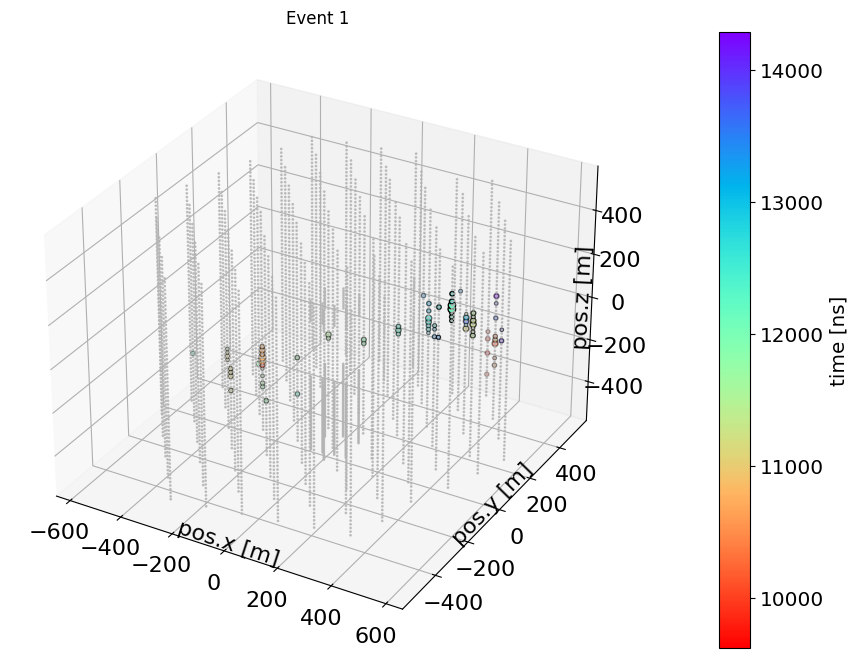

In [77]:
index = 1
meta, pulses = get_event_data(index)
event_data = get_per_dom_summary_from_sim_data(meta, pulses)
replace_early_pulse(event_data, pulses)
ix = event_data['charge'].argmax()

# and remember the ID of the brightest sensor.
brightest_sensor_id = event_data.loc[ix, 'sensor_id']

# just FYI, in case you want to know the string and dom:
string, om = divmod(brightest_sensor_id, 60)
string += 1 # string indexing starts at 1 IceCube
om += 1 # om indexing starts at 1 in IceCube
print(f"selected DOM is located on IceCube string {string} and is number {om}.")
plot_event(event_data, index, geo=geo)

event_id                   226450088406994.0
idx_start                                0.0
idx_end                                 51.0
n_channel_HLC                           24.0
neutrino_energy                897586.308942
muon_energy                     875087.42632
muon_energy_at_detector          4965.592742
muon_energy_lost                 4728.279815
q_tot                                   42.4
n_channel                               32.0
muon_zenith                         1.951349
muon_azimuth                        2.163309
muon_time                      -13500.179522
muon_pos_x                      -3368.980538
muon_pos_y                       5823.786306
muon_pos_z                      -2542.865871
spline_mpe_zenith                   1.959804
spline_mpe_azimuth                  2.177216
spline_mpe_time                 10826.712431
spline_mpe_pos_x                  412.627667
spline_mpe_pos_y                  209.364015
spline_mpe_pos_z                  166.321029
Name: 5024

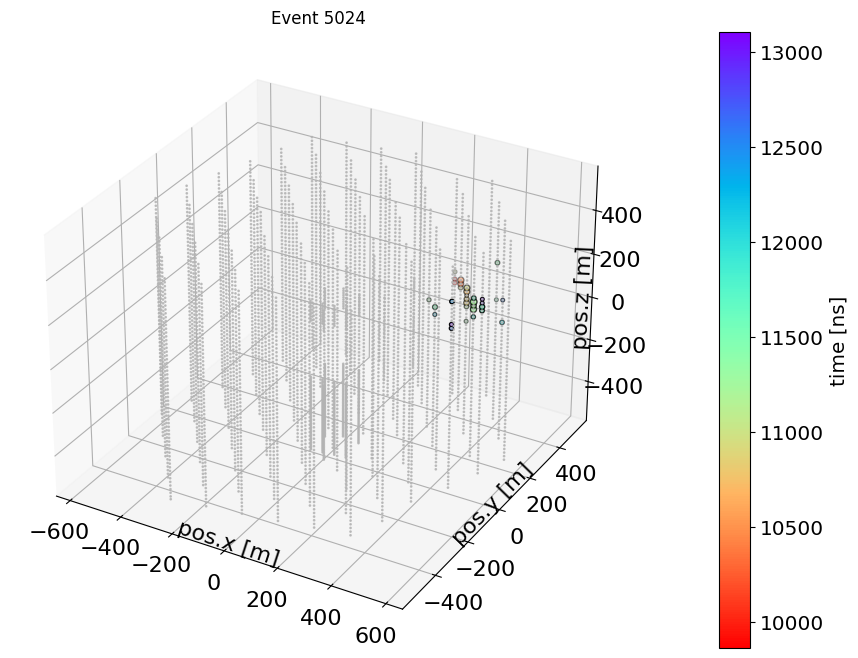

In [50]:
index = high_idx
meta, pulses = get_event_data(index)
event_data = get_per_dom_summary_from_sim_data(meta, pulses)
replace_early_pulse(event_data, pulses)
ix = event_data['charge'].argmax()

# and remember the ID of the brightest sensor.
brightest_sensor_id = event_data.loc[ix, 'sensor_id']

# just FYI, in case you want to know the string and dom:
string, om = divmod(brightest_sensor_id, 60)
string += 1 # string indexing starts at 1 IceCube
om += 1 # om indexing starts at 1 in IceCube
print(f"selected DOM is located on IceCube string {string} and is number {om}.")
plot_event(event_data, index, geo=geo)

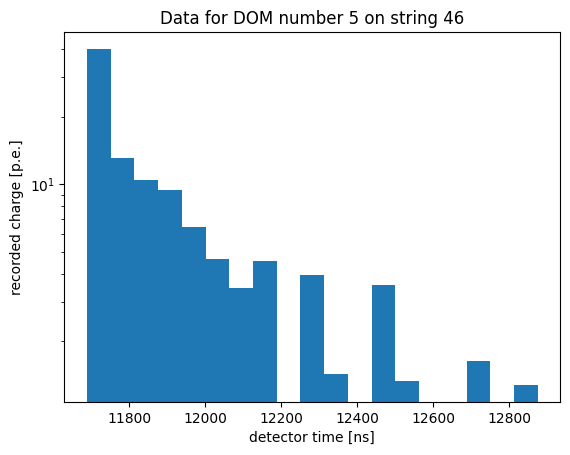

In [72]:
# let's visualize pulses
min_time = pulses_this_dom['time'].min()
max_time = pulses_this_dom['time'].max()
time_bins = np.linspace(min_time, max_time, 20)

plt.figure()
plt.hist(pulses_this_dom['time'], bins=time_bins, weights=pulses_this_dom['charge'])
plt.yscale('log')
plt.ylabel("recorded charge [p.e.]")
plt.xlabel("detector time [ns]")
plt.title(f"Data for DOM number {om} on string {string}")
plt.show()

In [31]:
with PdfPages("output.pdf") as pdf:
    for i in range(20, 30):
        index = i
        meta, pulses = get_event_data(index)
        event_data = get_per_dom_summary_from_sim_data(meta, pulses)
        replace_early_pulse(event_data, pulses)
        ix = event_data['charge'].argmax()

        # and remember the ID of the brightest sensor.
        brightest_sensor_id = event_data.loc[ix, 'sensor_id']
        print("")

        # just FYI, in case you want to know the string and dom:
        string, om = divmod(brightest_sensor_id, 60)
        string += 1 # string indexing starts at 1 IceCube
        om += 1 # om indexing starts at 1 in IceCube
        print(f"selected DOM is located on IceCube string {string} and is number {om}.")
        plot_event(event_data, geo=geo, plot_pdf=True)
        d = pdf.infodict()
        d['Title'] = 'My analysis plots'
        d['Author'] = 'Rishi Babu'
        d['Subject'] = 'Pulse/meta data visualization'
        d['Keywords'] = 'IceCube, muons, matplotlib'


selected DOM is located on IceCube string 56 and is number 56.

selected DOM is located on IceCube string 39 and is number 49.

selected DOM is located on IceCube string 59 and is number 47.

selected DOM is located on IceCube string 44 and is number 59.

selected DOM is located on IceCube string 56 and is number 28.

selected DOM is located on IceCube string 76 and is number 19.

selected DOM is located on IceCube string 28 and is number 7.

selected DOM is located on IceCube string 57 and is number 20.

selected DOM is located on IceCube string 67 and is number 58.

selected DOM is located on IceCube string 55 and is number 4.


In [34]:
pulses_this_dom

,event_id,sensor_id,time,charge,is_HLC
774257,226450088406994,2897,11226.0,1.725,1
774258,226450088406994,2897,11241.0,2.225,1
774259,226450088406994,2897,11267.0,1.125,1


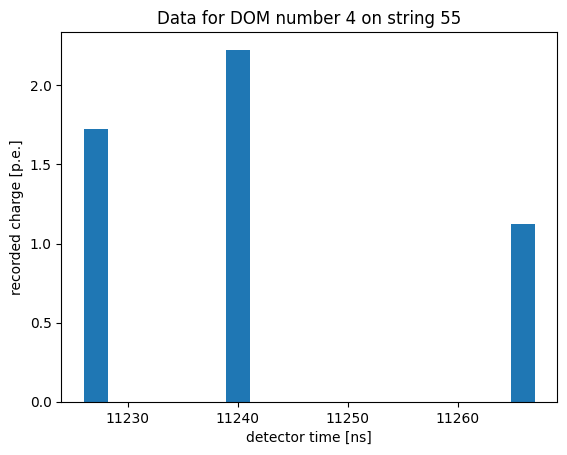

In [32]:
# let's visualize pulses
min_time = pulses_this_dom['time'].min()
max_time = pulses_this_dom['time'].max()
time_bins = np.linspace(min_time, max_time, 20)

plt.figure()
plt.hist(pulses_this_dom['time'], bins=time_bins, weights=pulses_this_dom['charge'])
# plt.yscale('log')
plt.ylabel("recorded charge [p.e.]")
plt.xlabel("detector time [ns]")
plt.title(f"Data for DOM number {om} on string {string}")
plt.show()

In [130]:
counts, bin_edges = np.histogram(pulses_this_dom['time'], bins=time_bins, density=False)

# Convert counts to PDF (sum to 1)
pdf = counts / counts.sum()

# Bin centers for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

print("Bin centers:", bin_centers)
print("PDF:", pdf)

Bin centers: [13117.42105263 13124.26315789 13131.10526316 13137.94736842
 13144.78947368 13151.63157895 13158.47368421 13165.31578947
 13172.15789474 13179.         13185.84210526 13192.68421053
 13199.52631579 13206.36842105 13213.21052632 13220.05263158
 13226.89473684 13233.73684211 13240.57894737]
PDF: [0.1 0.2 0.  0.1 0.  0.  0.1 0.  0.1 0.  0.  0.1 0.  0.1 0.1 0.  0.  0.
 0.1]


x grid: [13114.         13115.31313131 13116.62626263 13117.93939394
 13119.25252525 13120.56565657 13121.87878788 13123.19191919
 13124.50505051 13125.81818182 13127.13131313 13128.44444444
 13129.75757576 13131.07070707 13132.38383838 13133.6969697
 13135.01010101 13136.32323232 13137.63636364 13138.94949495
 13140.26262626 13141.57575758 13142.88888889 13144.2020202
 13145.51515152 13146.82828283 13148.14141414 13149.45454545
 13150.76767677 13152.08080808 13153.39393939 13154.70707071
 13156.02020202 13157.33333333 13158.64646465 13159.95959596
 13161.27272727 13162.58585859 13163.8989899  13165.21212121
 13166.52525253 13167.83838384 13169.15151515 13170.46464646
 13171.77777778 13173.09090909 13174.4040404  13175.71717172
 13177.03030303 13178.34343434 13179.65656566 13180.96969697
 13182.28282828 13183.5959596  13184.90909091 13186.22222222
 13187.53535354 13188.84848485 13190.16161616 13191.47474747
 13192.78787879 13194.1010101  13195.41414141 13196.72727273
 13198.04040404 13

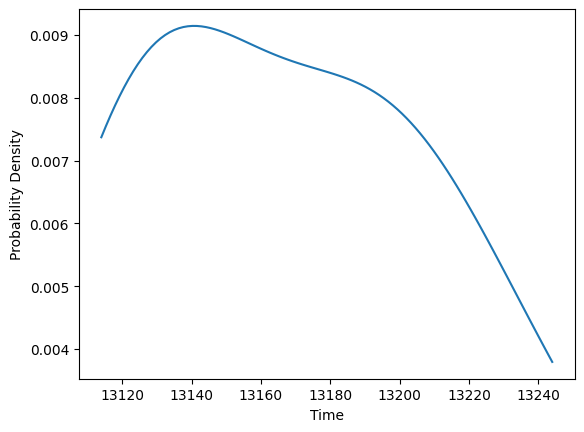

In [131]:
from scipy.stats import gaussian_kde

# Kernel Density Estimate
time_array=pulses_this_dom['time']
kde = gaussian_kde(time_array)

# Evaluate PDF on a grid
x_grid = np.linspace(time_array.min(), time_array.max(), 100)
pdf_values = kde(x_grid)

# Normalize to make sure integral = 1
pdf_values /= np.trapz(pdf_values, x_grid)

print("x grid:", x_grid)
print("PDF values:", pdf_values)
import matplotlib.pyplot as plt

plt.plot(x_grid, pdf_values)
plt.xlabel("Time")
plt.ylabel("Probability Density")
plt.show()